In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
from sklearn import linear_model
from sklearn.metrics import r2_score
from adjustText import adjust_text
from functools import partial
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
pd.set_option('chained_assignment',None)
from matplotlib.backends.backend_pdf import PdfPages

In [15]:
main_data = pd.read_csv('C:/Users/lzoeckler/Desktop/4plex/output_data/final_dilutions.csv')
main_data.head()

,patient_id,time_point_days,errors,HRP2_pg_ml,HRP2_pg_ml_dilution,HRP2_pg_ml_well,HRP2_pg_ml_max_dilution,LDH_Pan_pg_ml,LDH_Pan_pg_ml_dilution,LDH_Pan_pg_ml_well,LDH_Pan_pg_ml_max_dilution,LDH_Pv_pg_ml,LDH_Pv_pg_ml_dilution,LDH_Pv_pg_ml_well,LDH_Pv_pg_ml_max_dilution,CRP_ng_ml,CRP_ng_ml_dilution,CRP_ng_ml_well,CRP_ng_ml_max_dilution
0,pa-001,3,NaN,318702.59,2500,e3,312500000.0,142.30,1,g6,312500000.0,15.35,1,g6,312500000.0,5678.58,1,g6,312500000.0
1,pa-001,7,NaN,73737.79,2500,c5,125000.0,179.34,1,e12,125000.0,10.31,1,e12,125000.0,1021.09,1,e12,125000.0
2,pa-001,14,NaN,4138.79,50,d8,50.0,< 14.41,1,c8,50.0,2.76,1,c8,50.0,7064.05,1,c8,50.0
3,pa-001,21,NaN,1377.18,50,d12,50.0,38.94,1,c12,50.0,12.21,1,c12,50.0,2413.65,1,c12,50.0
4,pa-001,28,NaN,2024.41,50,h2,50.0,29.86,1,g2,50.0,13.90,1,g2,50.0,92.87,1,g2,50.0


In [16]:
analyte_name_dict = {'HRP2_pg_ml': ('HRP2', 'pg/ml'), 'LDH_Pan_pg_ml': ('LDH_Pan', 'pg/ml'),
                     'LDH_Pv_pg_ml': ('LDH_Pv', 'pg/ml'), 'CRP_ng_ml': ('CRP', 'ng/ml')}

In [17]:
analytes = ['HRP2_pg_ml', 'LDH_Pan_pg_ml', 'LDH_Pv_pg_ml', 'CRP_ng_ml']

In [18]:
def clean_strings(val):
    clean = val.replace('<', '')
    clean = clean.replace('>', '')
    if clean == 'fail':
        return np.nan
    return clean

In [19]:
all_colors = cm.rainbow(np.linspace(0, 1, 8))
all_dilutions = ['1', '50', '2500', '125000', '6250000', '312500000', '15625000000', '781250000000']
all_shapes = ['+', 'v', 's', 'p', 'd', '^', '.', '*']
color_combo = zip(all_dilutions, all_colors)
color_dict = {dil: val for dil, val in color_combo}
color_dict['fail'] = np.array([0.0,0.0,0.0,0.0])
shape_combo = zip(all_dilutions, all_shapes)
shape_dict = {dil: val for dil, val in shape_combo}
for analyte in analytes:
# for analyte in ['HRP2_pg_ml']:
    pp = PdfPages('C:/Users/lzoeckler/Desktop/4plex/output_data/{}_shapes.pdf'.format(analyte))
    for pid in main_data['patient_id'].unique():
#     for pid in ['pa-001','pa-026']:
        pid_data = main_data.loc[main_data['patient_id'] == pid]
        plot_data = pid_data[['patient_id', 'time_point_days', analyte,
                              '{}_dilution'.format(analyte),
                              '{}_max_dilution'.format(analyte)]]
        plot_data[analyte] = plot_data[analyte].apply(clean_strings)
        plot_data[analyte] = plot_data[analyte].apply(float)
        vals = plot_data[analyte].tolist()
        try:
            if (vals[0] < vals[1]) | (vals[0] < vals[2]):
                plt_color = 'red'
            else:
                plt_color = 'blue'
        except:
            plt_color = 'blue'
        f = plt.figure()
        ax = f.add_subplot()
        plot = plt.plot(plot_data['time_point_days'], plot_data[analyte], color=plt_color,
                        alpha=0.3)
        dil_vals = plot_data['{}_dilution'.format(analyte)].tolist()
        dil_vals = [str(val) if val != 'fail' else val for val in dil_vals]
        vals = plot_data[analyte].tolist()
        time = plot_data['time_point_days'].tolist()
        maximum = plot_data['{}_max_dilution'.format(analyte)]
        data = zip(time, vals)
        color_legend = []
        used_dil = []
        shape_legend = []
        used_shapes = []
        for data, group, max_dil in zip(data, dil_vals, maximum):
            x, y = data
            color = color_dict[group]
            max_dil = str(int(max_dil))
            shape = shape_dict[max_dil]
            scatter = plt.scatter(x, y, c=[color], marker=shape, s=120, alpha=1.0)
            if group not in used_dil:
                color_legend.append(Line2D([0], [0], marker='o', color='w', label=group,
                                          markerfacecolor=color, markersize=15))
                used_dil.append(group)
            if shape not in used_shapes:
                shape_legend.append(Line2D([0], [0], marker=shape, color='w', label=max_dil,
                                          markerfacecolor='k', markersize=15))
                used_shapes.append(shape)
        plt.yscale('log')
        title = "analyte: {}, patient_id: {}".format(analyte, pid)
        plt.title(title)
        first_legend = plt.legend(handles=color_legend, loc='best',
                                  title='Dilution used')
        second_legend = plt.legend(handles=shape_legend,
                                   bbox_to_anchor=(1.00, 0.5),
                                   title='Max dilution')
        plt.gca().add_artist(first_legend)
        plt.tight_layout()
        pp.savefig(f, bbox_extra_artists=[first_legend, second_legend], bbox_inches='tight')
        plt.close()
    pp.close()

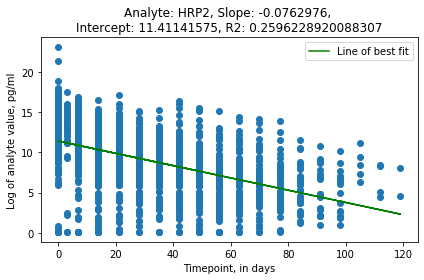

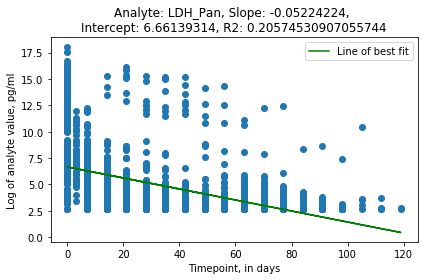

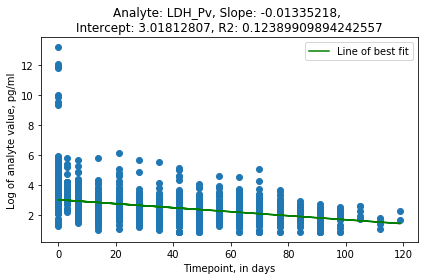

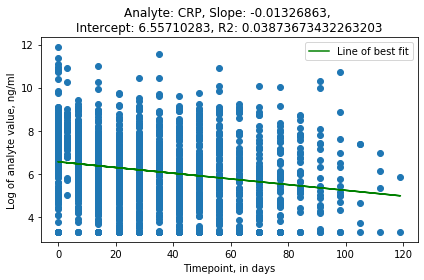

In [20]:
for analyte in analytes:
# for analyte in ['HRP2_pg_ml']:
    pp = PdfPages('C:/Users/lzoeckler/Desktop/4plex/output_data/{}_all_individuals.pdf'.format(analyte))
    plot_data = main_data[['patient_id', 'time_point_days', analyte,
                          '{}_dilution'.format(analyte),
                          '{}_max_dilution'.format(analyte)]]
    plot_data[analyte] = plot_data[analyte].apply(clean_strings)
    plot_data[analyte] = plot_data[analyte].apply(float)
    plot_data[analyte] = plot_data[analyte].apply(math.log)
    regr = linear_model.LinearRegression()
    time = plot_data['time_point_days'].values.reshape(-1,1)
    val = plot_data[analyte].values.reshape(-1,1)
    regr.fit(time, val)
    pred = regr.predict(time)
    score = r2_score(val, pred)
    coef = np.float(regr.coef_)
    intercept = np.float(regr.intercept_)
    f = plt.figure()
    plt.scatter(time, val)
    plt.plot(time, pred, color='green', label="Line of best fit")
    true_analyte = analyte_name_dict[analyte][0]
    units = analyte_name_dict[analyte][1]
    title = """Analyte: {}, Slope: {}, \nIntercept: {}, R2: {}""".format(
            true_analyte, round(coef, 8), round(intercept, 8), score)
    plt.title(title)
    plt.xlabel("Timepoint, in days")
    plt.ylabel("Log of analyte value, {}".format(units))
    plt.legend()
    plt.tight_layout()
    pp.savefig(f)
    plt.close()
    pp.close()

In [23]:
for analyte in analytes:
# for analyte in ['HRP2_pg_ml']:
    pp = PdfPages('C:/Users/lzoeckler/Desktop/4plex/output_data/{}_all_connected.pdf'.format(analyte))
    f = plt.figure()
    ax = f.add_subplot()
    for pid in main_data['patient_id'].unique():
#     for pid in ['pa-001','pa-026']:
        pid_data = main_data.loc[main_data['patient_id'] == pid]
        plot_data = pid_data[['patient_id', 'time_point_days', analyte,
                              '{}_dilution'.format(analyte),
                              '{}_max_dilution'.format(analyte)]]
        plot_data[analyte] = plot_data[analyte].apply(clean_strings)
        plot_data[analyte] = plot_data[analyte].apply(float)
        plot_data[analyte] = plot_data[analyte].apply(math.log)
        vals = plot_data[analyte].tolist()
        plot = plt.plot(plot_data['time_point_days'], plot_data[analyte])
    true_analyte = analyte_name_dict[analyte][0]
    units = analyte_name_dict[analyte][1]
    plt.title('Individuals over time\nAnalyte: {}'.format(true_analyte))
    plt.xlabel("Timepoint, in days")
    plt.ylabel("Log of analyte value, {}".format(units))
    plt.tight_layout()
    pp.savefig(f)
    plt.close()
    pp.close()